In [68]:
import hashlib
import hmac
import time
import requests
import urllib3
import pandas as pd
import mplfinance as mpf
from typing import Literal
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

_RESOLUTIONS = Literal[1,5,15,60,240,"1D"]

urllib3.disable_warnings()

In [69]:
def gen_sign(api_secret, payload_string=None):
    return hmac.new(api_secret.encode('utf-8'), payload_string.encode('utf-8'), hashlib.sha256).hexdigest()

def gen_query_param(url, query_param):
    req = requests.PreparedRequest()
    req.prepare_url(url, query_param)
    return req.url.replace(url,"")

In [70]:
def get_tradingview_history(symbol, resolution: _RESOLUTIONS, days):
    host = 'https://api.bitkub.com'
    path = '/tradingview/history'
    api_key = ''
    api_secret = ''

    # Get 30 days candlestick data of ZIL/THB
    time_from = round(time.time()) - days*24*60*60
    time_to = round(time.time())

    ts = str(round(time.time() * 1000))
    param = {
        'symbol':"{}_THB".format(symbol),
        'resolution':resolution,
        'from':time_from,
        'to':time_to
    }
    query_param = gen_query_param(host+path, param)

    payload = []
    payload.append(ts)
    payload.append('GET')
    payload.append(path)
    payload.append(query_param)

    sig = gen_sign(api_secret, ''.join(payload))
    headers = {
        'Accept': 'application/json',
        'Content-Type': 'application/json',
        'X-BTK-TIMESTAMP': ts,
        'X-BTK-SIGN': sig,
        'X-BTK-APIKEY': api_key
    }

    return requests.request('GET', f'{host}{path}{query_param}', headers=headers, data={}, verify=False).json()

/Users/khachenthammasathidkul/.pyenv/versions/3.10.0/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


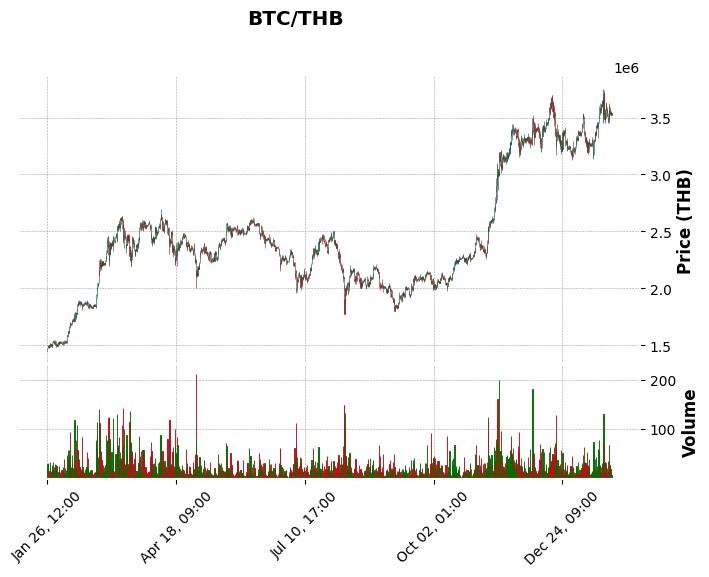

In [143]:
# plot candlestick chart
symbol = 'BTC'
df = pd.DataFrame(get_tradingview_history(symbol, 240, 365))
df.columns = ['Close', 'Open', 'High', 'Low', 'Volume', 'Time', 'Status']
df['Time'] = pd.to_datetime(df['Time'], unit='s')
df.set_index('Time', inplace=True)
df = df.drop(columns=['Status'])
mpf.plot(df, type='candle', volume=True, style='charles', title="{}/THB".format(symbol), ylabel='Price (THB)', ylabel_lower='Volume', figratio=(12,8), figscale=1.0)

Epoch 1/10


/Users/khachenthammasathidkul/.pyenv/versions/3.10.0/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0339
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0011
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.2692e-04
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.3366e-04
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.1568e-04
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.3431e-04
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.3297e-04
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.3756e-04
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.6231e-04
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.6567e-04
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


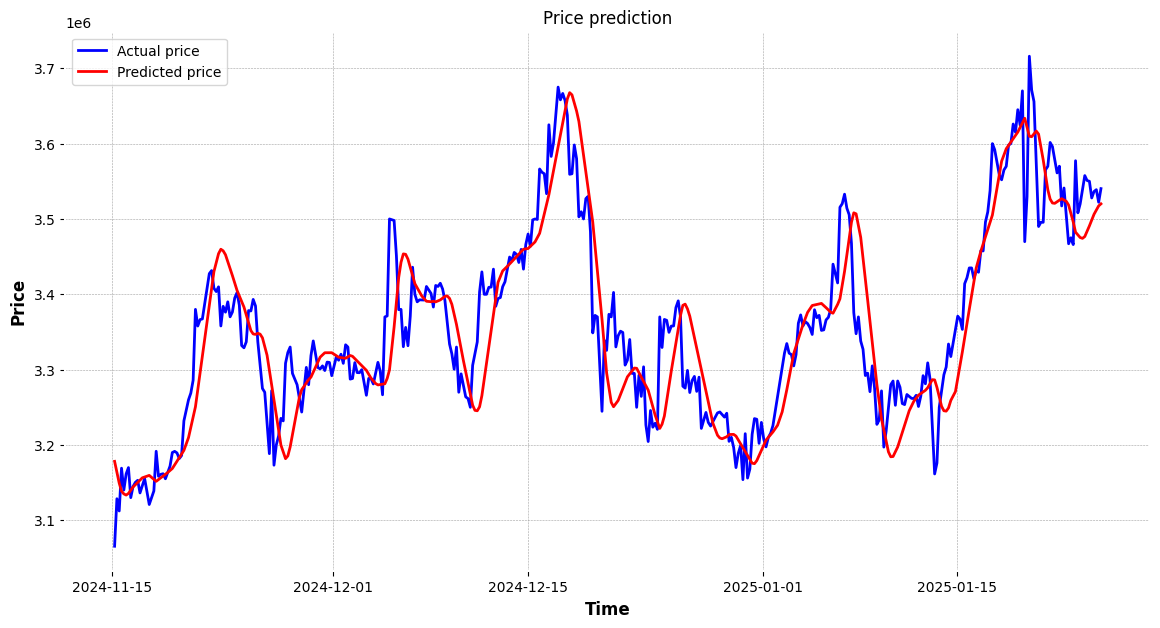

In [148]:
# Normalize the close price
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Prepare the data for LSTM
lookback = 60  # Use past 60 days to predict
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  # Predict next close price

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions
predicted_price = model.predict(X_test)

# Inverse transform the predicted prices to actual values
predicted_price = scaler.inverse_transform(predicted_price)

# Plot the actual and predicted prices
plt.figure(figsize=(14,7))
plt.plot(df.index[-len(y_test):], df['Close'].values[-len(y_test):], label='Actual price', color='blue')
plt.plot(df.index[-len(y_test):], predicted_price, label='Predicted price', color='red')
plt.title('Price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()
